# EDA

We sourced the data from "optionsdx.com", downloaded the SPX options chain data for the whole year of 2023. The data came in four folders which were the four quarters of the year, each folder had 3 files which contained data for each month. We went with SPX because we plan to use Black-Scholes model and it workd well only with Eauropen style options and ETFs predominantly trade european style in the American market.

In [34]:
import pandas as pd 
import os

# List of folder names containing the files
folders = ['spx_eod_2023q1', 'spx_eod_2023q2', 'spx_eod_2023q3', 'spx_eod_2023q4']

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each folder and each file within the folder
for folder in folders:
    folder_path = os.path.join('/Users/pranav/Desktop/SU/AML_Project/', folder) 
    for filename in os.listdir(folder_path):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        # Read the file into a DataFrame
        df = pd.read_csv(file_path, sep=',')  # Adjust separator if necessary
        # Filter rows where DTE equals 7 because we only want 1 week expiration date
        filtered_df = df[df[' [DTE]'] == 7]
        # Append the filtered DataFrame to the list
        dfs.append(filtered_df)

# Concatenate all DataFrames in the list into a single DataFrame
merged_filtered_df = pd.concat(dfs, ignore_index=True)

/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_1689/2719280238.py:17: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=',')  # Adjust separator if necessary
/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_1689/2719280238.py:17: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=',')  # Adjust separator if necessary


In [35]:
merged_filtered_df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,0.0,0.0,0.00176,-0.01785,-0.00023,2.560080,,2853.4,0.740
1,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,-0.00041,0.0,0.0016,-0.01773,-0.00054,2.220070,,2653.4,0.689
2,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,0.0,0.0,0.00168,-0.01682,0.0,1.933810,,2453.4,0.637
3,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,0.0,0.0,0.00226,-0.01734,-0.00055,1.687580,,2253.4,0.585
4,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,-0.00035,0.0,0.00232,-0.01689,-0.00016,1.469090,,2053.4,0.533


Checking if the date range is correct

In [36]:
merged_filtered_df[' [QUOTE_DATE]'] = pd.to_datetime(merged_filtered_df[' [QUOTE_DATE]'])
start_date = merged_filtered_df[' [QUOTE_DATE]'].min()
end_date = merged_filtered_df[' [QUOTE_DATE]'].max()
print("Start Date: ", start_date, "End Date: ", end_date)

Start Date:  2023-01-04 00:00:00 End Date:  2023-12-29 00:00:00


Checking for nulls

In [37]:
merged_filtered_df.isnull().sum()

[QUOTE_UNIXTIME]          0
 [QUOTE_READTIME]         0
 [QUOTE_DATE]             0
 [QUOTE_TIME_HOURS]       0
 [UNDERLYING_LAST]        0
 [EXPIRE_DATE]            0
 [EXPIRE_UNIX]            0
 [DTE]                    0
 [C_DELTA]                0
 [C_GAMMA]                0
 [C_VEGA]                 0
 [C_THETA]                0
 [C_RHO]                  0
 [C_IV]                   0
 [C_VOLUME]               0
 [C_LAST]                 0
 [C_SIZE]                 0
 [C_BID]                  0
 [C_ASK]                  0
 [STRIKE]                 0
 [P_BID]                  0
 [P_ASK]                  0
 [P_SIZE]                 0
 [P_LAST]                 0
 [P_DELTA]                0
 [P_GAMMA]                0
 [P_VEGA]                 0
 [P_THETA]                0
 [P_RHO]                  0
 [P_IV]                   0
 [P_VOLUME]               0
 [STRIKE_DISTANCE]        0
 [STRIKE_DISTANCE_PCT]    0
dtype: int64

Merging data with FRED data which has risk-free rate data, imputing missing values with feed forward technique

In [38]:
df = merged_filtered_df

import pandas_datareader.data as web

# Fetch the data
risk_free_rate_data = web.DataReader('DTB3', 'fred', start_date, end_date)

# Convert the index to a datetime format if it's not already
risk_free_rate_data.index = pd.to_datetime(risk_free_rate_data.index)

df[' [QUOTE_DATE]'] = pd.to_datetime(df[' [QUOTE_DATE]'])

# Merge the datasets
df = df.merge(risk_free_rate_data, how='left', left_on=' [QUOTE_DATE]', right_index=True)

# Forward fill missing values for the DTB3 column
df['DTB3'] = df['DTB3'].fillna(method='bfill')

/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_1689/1184696341.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['DTB3'] = df['DTB3'].fillna(method='bfill')


In [39]:
df.head()

,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],DTB3
0,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,0.0,0.00176,-0.01785,-0.00023,2.560080,,2853.4,0.740,4.41
1,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,-0.00041,0.0,0.0016,-0.01773,-0.00054,2.220070,,2653.4,0.689,4.41
2,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,0.0,0.00168,-0.01682,0.0,1.933810,,2453.4,0.637,4.41
3,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,0.0,0.0,0.00226,-0.01734,-0.00055,1.687580,,2253.4,0.585,4.41
4,1672866000,2023-01-04 16:00,2023-01-04,16.0,3853.39,2023-01-11,1673470800,7.0,1.0,0.0,...,-0.00035,0.0,0.00232,-0.01689,-0.00016,1.469090,,2053.4,0.533,4.41


Checking for nulls again

In [40]:
df.isnull().sum()

[QUOTE_UNIXTIME]          0
 [QUOTE_READTIME]         0
 [QUOTE_DATE]             0
 [QUOTE_TIME_HOURS]       0
 [UNDERLYING_LAST]        0
 [EXPIRE_DATE]            0
 [EXPIRE_UNIX]            0
 [DTE]                    0
 [C_DELTA]                0
 [C_GAMMA]                0
 [C_VEGA]                 0
 [C_THETA]                0
 [C_RHO]                  0
 [C_IV]                   0
 [C_VOLUME]               0
 [C_LAST]                 0
 [C_SIZE]                 0
 [C_BID]                  0
 [C_ASK]                  0
 [STRIKE]                 0
 [P_BID]                  0
 [P_ASK]                  0
 [P_SIZE]                 0
 [P_LAST]                 0
 [P_DELTA]                0
 [P_GAMMA]                0
 [P_VEGA]                 0
 [P_THETA]                0
 [P_RHO]                  0
 [P_IV]                   0
 [P_VOLUME]               0
 [STRIKE_DISTANCE]        0
 [STRIKE_DISTANCE_PCT]    0
DTB3                      0
dtype: int64

Merging Spot price data from Yahoo Finance

In [41]:
import yfinance as yf

# Fetch SPX data using yfinance
spx = yf.Ticker("^SPX")
hist = spx.history(start=start_date, end=end_date)

# The 'Close' column in 'hist' represents the closing price; we'll use it as the spot price
# Rename 'Close' to 'Spot_Price' for clarity
hist.rename(columns={'Close': 'Spot_Price'}, inplace=True)

# Reset the index to make the 'Date' column usable for merging
hist = hist.reset_index()

# Convert the 'Date' column in the fetched data to be timezone-naive
hist['Date'] = hist['Date'].dt.tz_localize(None)

# Now, let's merge this data back into your original DataFrame
# We're merging on the 'date' column from your DataFrame and the 'Date' column from the fetched data
df_merged = pd.merge(df, hist[['Date', 'Spot_Price']], left_on=' [QUOTE_DATE]', right_on='Date', how='left')

# Drop the extra 'Date' column if it's redundant
df_merged.drop(columns=['Date'], inplace=True)

Checking for nulls

In [42]:
df_merged.isnull().sum()

[QUOTE_UNIXTIME]            0
 [QUOTE_READTIME]           0
 [QUOTE_DATE]               0
 [QUOTE_TIME_HOURS]         0
 [UNDERLYING_LAST]          0
 [EXPIRE_DATE]              0
 [EXPIRE_UNIX]              0
 [DTE]                      0
 [C_DELTA]                  0
 [C_GAMMA]                  0
 [C_VEGA]                   0
 [C_THETA]                  0
 [C_RHO]                    0
 [C_IV]                     0
 [C_VOLUME]                 0
 [C_LAST]                   0
 [C_SIZE]                   0
 [C_BID]                    0
 [C_ASK]                    0
 [STRIKE]                   0
 [P_BID]                    0
 [P_ASK]                    0
 [P_SIZE]                   0
 [P_LAST]                   0
 [P_DELTA]                  0
 [P_GAMMA]                  0
 [P_VEGA]                   0
 [P_THETA]                  0
 [P_RHO]                    0
 [P_IV]                     0
 [P_VOLUME]                 0
 [STRIKE_DISTANCE]          0
 [STRIKE_DISTANCE_PCT]      0
DTB3      

Drop rows which contained null values

In [43]:
#column you want to check for NaN values
column_name = 'Spot_Price' 

# Drop rows where the specified column has NaN values
df_cleaned = df_merged.dropna(subset=[column_name])

In [44]:
df_cleaned.isnull().sum()

[QUOTE_UNIXTIME]          0
 [QUOTE_READTIME]         0
 [QUOTE_DATE]             0
 [QUOTE_TIME_HOURS]       0
 [UNDERLYING_LAST]        0
 [EXPIRE_DATE]            0
 [EXPIRE_UNIX]            0
 [DTE]                    0
 [C_DELTA]                0
 [C_GAMMA]                0
 [C_VEGA]                 0
 [C_THETA]                0
 [C_RHO]                  0
 [C_IV]                   0
 [C_VOLUME]               0
 [C_LAST]                 0
 [C_SIZE]                 0
 [C_BID]                  0
 [C_ASK]                  0
 [STRIKE]                 0
 [P_BID]                  0
 [P_ASK]                  0
 [P_SIZE]                 0
 [P_LAST]                 0
 [P_DELTA]                0
 [P_GAMMA]                0
 [P_VEGA]                 0
 [P_THETA]                0
 [P_RHO]                  0
 [P_IV]                   0
 [P_VOLUME]               0
 [STRIKE_DISTANCE]        0
 [STRIKE_DISTANCE_PCT]    0
DTB3                      0
Spot_Price                0
dtype: int64

As you can see below the column names are not in a good format, we will remove the aquare brackets and remove any unnecessary white spaces

In [45]:
df_cleaned.columns

Index(['[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]', 'DTB3', 'Spot_Price'],
      dtype='object')

In [46]:
# Create a dictionary to map old column names to new ones by stripping square brackets and white spaces
rename_dict = {col: col.replace('[', '').replace(']', '').strip() for col in df.columns}

# Rename the columns using the dictionary
df_cleaned.rename(columns=rename_dict, inplace=True)

# Optionally, to verify the new column names, you can print them
print(df_cleaned.columns)

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'DTB3',
       'Spot_Price'],
      dtype='object')


/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_1689/3063339560.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(columns=rename_dict, inplace=True)


Now we filter the DataFrame to keep only the required columns for Call Greeks and other necessary inputs for Black-Scholes model and ML model

In [47]:
columns_to_keep = [
    'Spot_Price',  # Current price of the underlying asset
    'STRIKE',  # Strike price of the option
    'DTE',  # Days to expiration
    'DTB3',  # Risk-free rate
    'C_IV',  # Implied volatility for call options
    'C_DELTA',  # Sensitivity of option price to changes in the price of the underlying asset
    'C_GAMMA',  # Rate of change in delta with respect to changes in the underlying price
    'C_VEGA',  # Sensitivity of option price to changes in volatility
    'C_THETA',  # Rate of decline in the value of an option due to the passage of time
    'C_RHO',  # Sensitivity of option price to changes in the risk-free interest rate
    'C_LAST',  # The most recent trading price of the call options
    'C_BID',  # Current bid price for call options
    'C_ASK', # Current ask price for call options
    'QUOTE_DATE', # Quoted date
    'EXPIRE_DATE' # Date of expire of the option
]

# Create a new DataFrame with only the selected columns
df_filtered = df_cleaned[columns_to_keep]

Converting values to numeric and adding calculating Black-Scholes call price

In [48]:
from scipy.stats import norm
import numpy as np

# Ensure the relevant columns are in numeric format
df_filtered['Spot_Price'] = pd.to_numeric(df_filtered['Spot_Price'], errors='coerce')
df_filtered['STRIKE'] = pd.to_numeric(df_filtered['STRIKE'], errors='coerce')
df_filtered['DTE'] = pd.to_numeric(df_filtered['DTE'], errors='coerce')
df_filtered['DTB3'] = pd.to_numeric(df_filtered['DTB3'], errors='coerce')
df_filtered['C_IV'] = pd.to_numeric(df_filtered['C_IV'], errors='coerce')

# Function to calculate the Black-Scholes option price for calls
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes option price for a call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    option_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return option_price

# Add a new column to the DataFrame for the Black-Scholes price
df_filtered['BS_Call_Price'] = df_filtered.apply(
    lambda row: black_scholes_call(
        S=row['Spot_Price'], 
        K=row['STRIKE'], 
        T=row['DTE']/365, 
        r=row['DTB3']/100,  # Ensure the risk-free rate is in decimal form
        sigma=row['C_IV']
    ), axis=1
)

/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_1689/946347692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Spot_Price'] = pd.to_numeric(df_filtered['Spot_Price'], errors='coerce')
/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_1689/946347692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['STRIKE'] = pd.to_numeric(df_filtered['STRIKE'], errors='coerce')
/var/folders/wb/jvzyl9390t3bhpxsrhb9fq9w0000gn/T/ipykernel_1689/946347692.py:7: SettingWithCopyW

In [49]:
len(df_filtered)

39170

Checking for nulls

In [50]:
df_filtered.isnull().sum()

Spot_Price          0
STRIKE              0
DTE                 0
DTB3                0
C_IV             2060
C_DELTA             0
C_GAMMA             0
C_VEGA              0
C_THETA             0
C_RHO               0
C_LAST              0
C_BID               0
C_ASK               0
QUOTE_DATE          0
EXPIRE_DATE         0
BS_Call_Price    2060
dtype: int64

Drop rows where values are null

In [51]:
# Drop rows where 'C_IV' is NaN
df_filtered = df_filtered.dropna(subset=['C_IV'])
# Drop rows where 'BS_Call_Price' is NaN
df_filtered = df_filtered.dropna(subset=['BS_Call_Price'])

In [52]:
df_filtered.isnull().sum()

Spot_Price       0
STRIKE           0
DTE              0
DTB3             0
C_IV             0
C_DELTA          0
C_GAMMA          0
C_VEGA           0
C_THETA          0
C_RHO            0
C_LAST           0
C_BID            0
C_ASK            0
QUOTE_DATE       0
EXPIRE_DATE      0
BS_Call_Price    0
dtype: int64

Saving Dataset

In [53]:
df_filtered.to_csv('/Users/pranav/Desktop/SU/AML_Project/filtered_dataset.csv', index=False)

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

Plotting correlation matrix

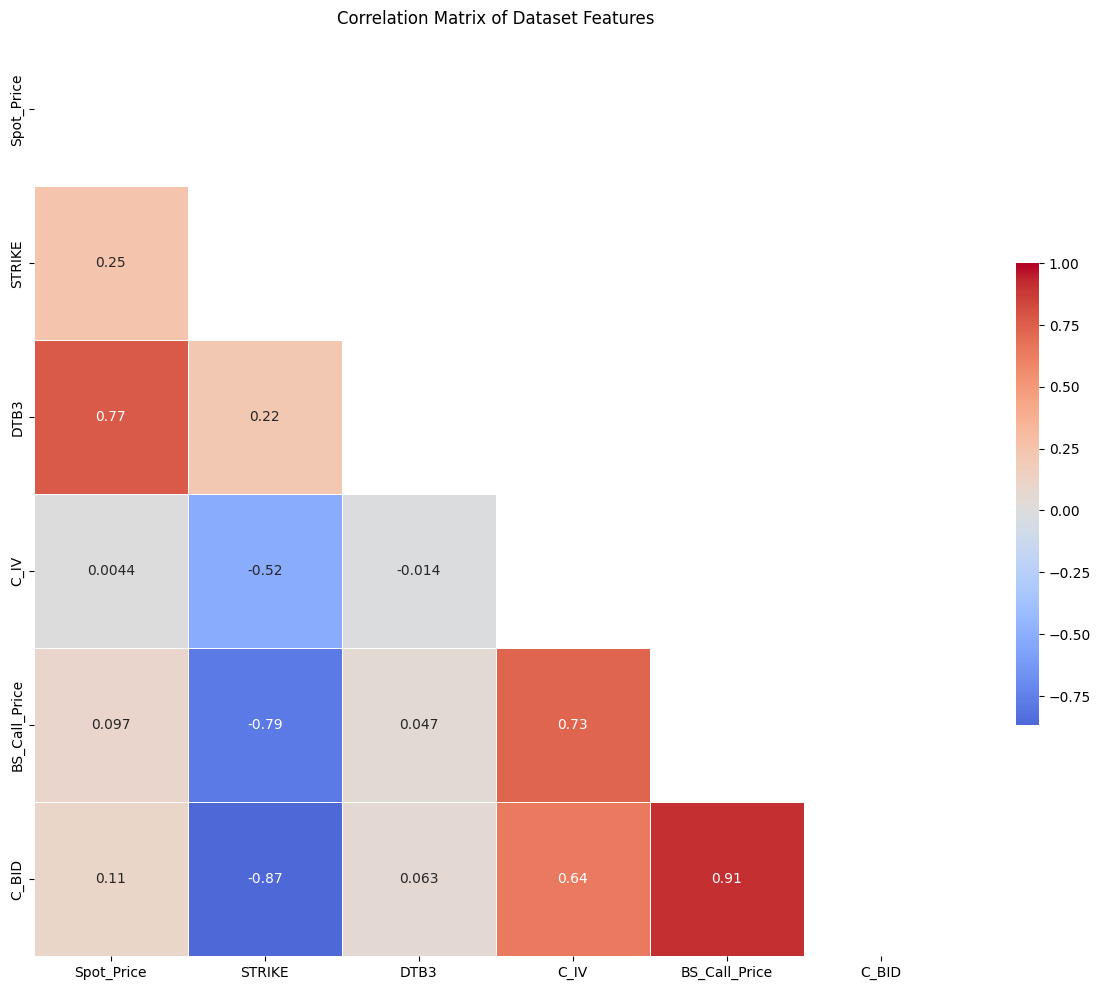

In [55]:
df = df_filtered[['Spot_Price', 'STRIKE', 'DTB3', 'C_IV', 'BS_Call_Price','C_BID']]

df = df.apply(pd.to_numeric, errors='coerce')

correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15, 12))

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Matrix of Dataset Features')
plt.show()

The correlation matrix depicted reveals various degrees of linear association between pairs of features in the dataset:

- Spot_Price and DTB3 exhibit a significant positive correlation of 0.77, indicating that as the spot price of the underlying asset increases, the risk-free rate (DTB3) tends to also increase, which may suggest that higher spot prices are associated with rising interest rates or economic conditions that lead to higher rates.

- A strong negative correlation of -0.79 is observed between STRIKE and BS_Call_Price, suggesting that as the strike price increases, the Black-Scholes model predicts a lower price for the call option, which is consistent with financial theory.

- The C_IV (implied volatility of call options) shows a substantial positive correlation of 0.91 with C_BID, implying that the bid price of call options tends to rise with increasing implied volatility, a relationship that aligns with the options pricing theory where higher volatility typically increases option premiums.

- Interestingly, C_IV has a moderate negative correlation with STRIKE (-0.52), indicating that options with higher strike prices may have lower implied volatility in this particular dataset.

- BS_Call_Price also has a strong positive correlation of 0.73 with C_BID, indicating that the model-predicted call prices align well with the bid prices in the market, which could suggest the model is effective at capturing market prices under certain conditions.

- Spot_Price and STRIKE show a mild positive correlation of 0.25, hinting at a slight tendency for options with higher strike prices to be associated with higher spot prices of the underlying asset.

- The other correlations involving Spot_Price, BS_Call_Price, and C_BID with DTB3 are relatively lower, indicating weaker linear relationships with the risk-free interest rate.

Overall, the strongest insights from this correlation matrix are the expected inverse relationship between strike price and call option price, and the strong linkage between implied volatility and option bid prices. The positive relationship between spot price and risk-free rate could reflect specific market or dataset conditions and warrants further investigation to understand the underlying dynamics.

Generating scatterplot matrix

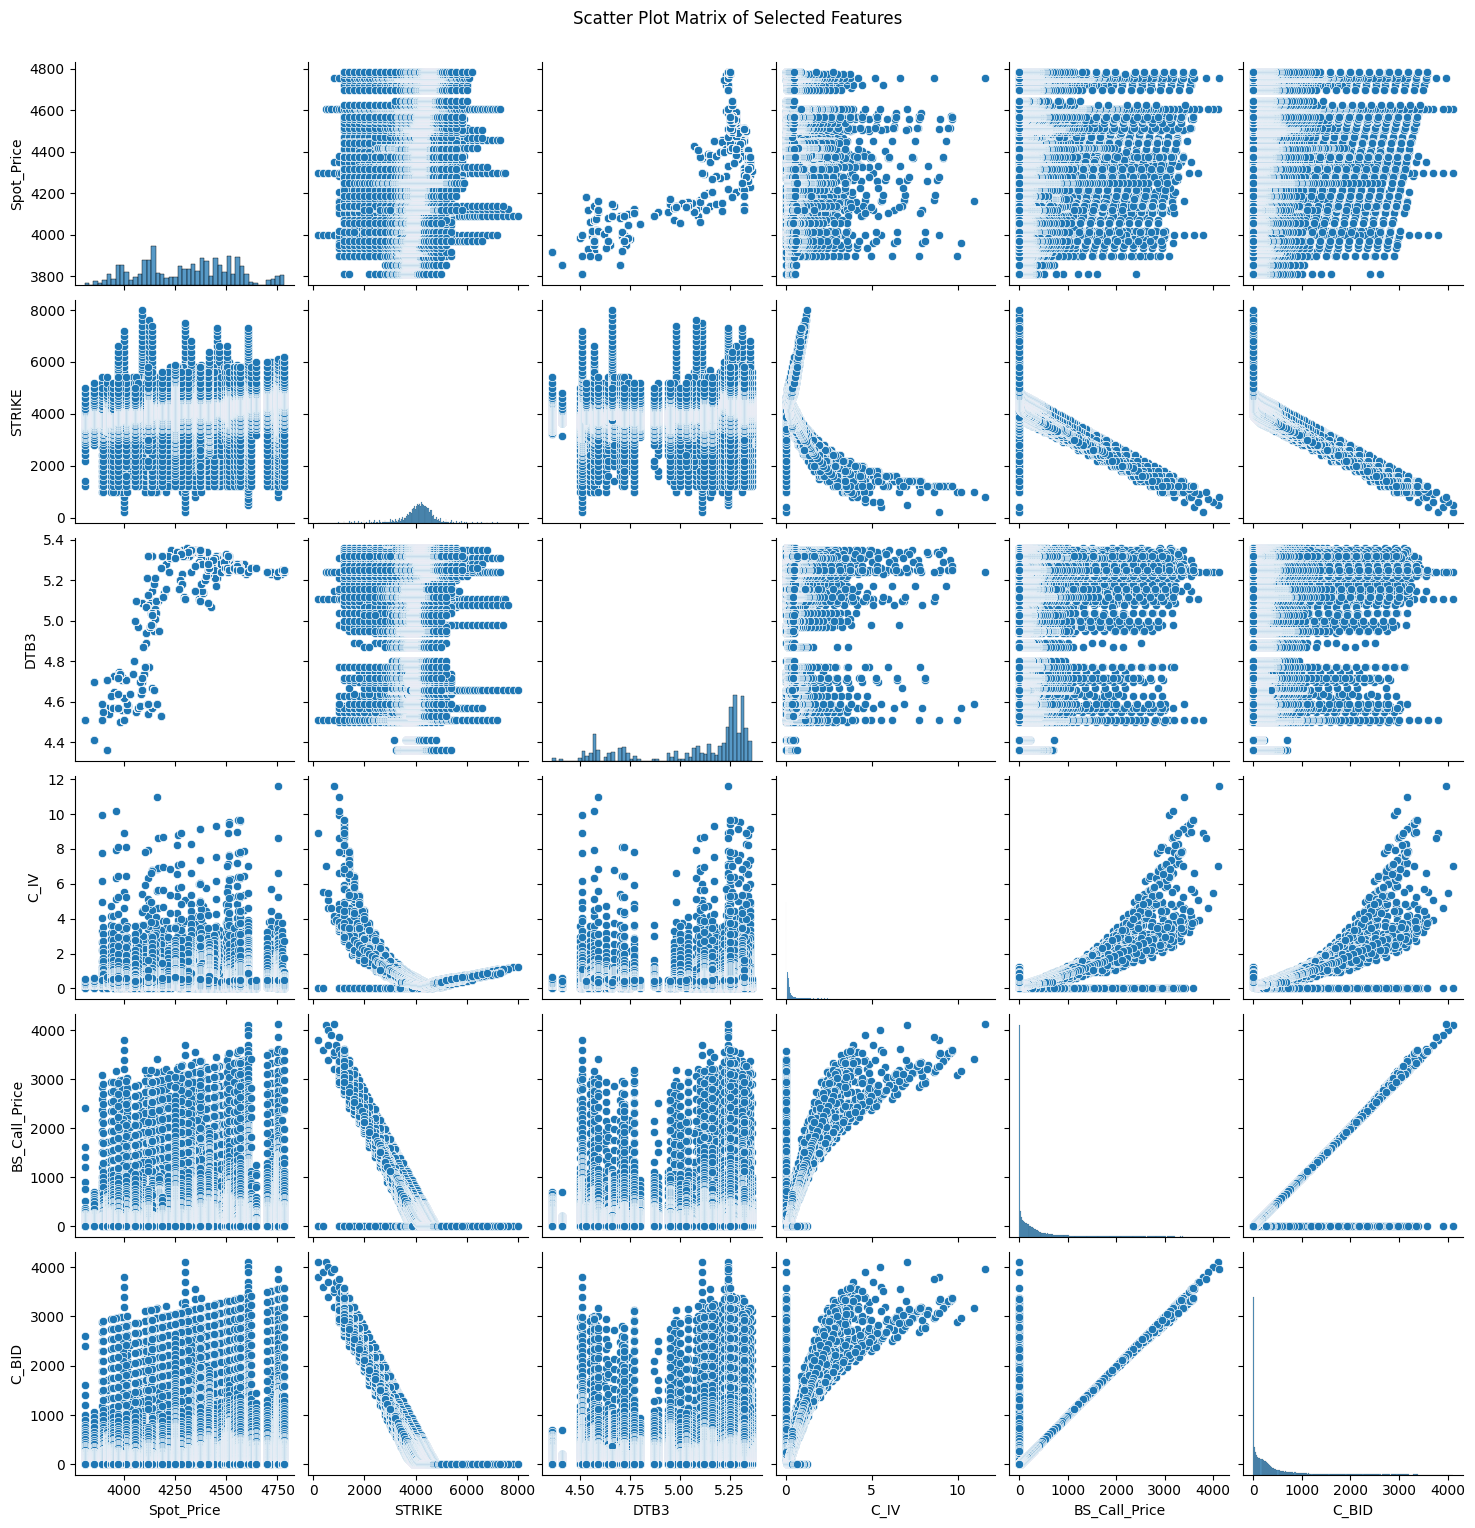

In [56]:
# Generate a pairplot
sns.pairplot(df)
plt.suptitle('Scatter Plot Matrix of Selected Features', y=1.02)  # Adjust title positioning
plt.show()

- The Spot_Price with STRIKE scatter plot doesn't depict a clear linear relationship, which corresponds with the mild correlation seen in the earlier correlation matrix. which makes sense as here appear to be a wide range of strikes for any given spot price.

- There is a notable pattern between Spot_Price and DTB3 which shows clustering at certain levels of DTB3, indicating that the risk-free rate has discrete values rather than a continuous range across different spot prices.

- The Spot_Price versus C_IV (Implied Volatility) scatter plot displays a funnel-like pattern, with a wide range of implied volatilities associated with lower spot prices, and a narrower range at higher spot prices. This could suggest volatility smile effects or a higher uncertainty in pricing for lower-priced assets.

- The STRIKE with C_IV plot also shows a pattern resembling a volatility skew, where higher strikes correspond to lower implied volatilities, which is typical in options markets.

- Both Spot_Price and STRIKE against BS_Call_Price display a downward sloping trend, indicating that call option prices decrease as strike prices increase, which is consistent with option pricing theory. Moreover, higher spot prices tend to be associated with higher call option prices.

- When looking at C_IV against BS_Call_Price and C_BID, there's a clear positive trend, reinforcing the correlation results that suggest implied volatility is positively related to option prices. Higher implied volatility often leads to higher option premiums, as seen in these plots.

- The BS_Call_Price versus C_BID scatter shows a tight, positive linear relationship, meaning the bid prices and Black-Scholes model prices for call options move closely together, which is expected since the bid price is often a reflection of the theoretical price.

These visual patterns confirm the numerical correlations and provide a deeper understanding of how each pair of variables interacts. The scatter plots are instrumental in identifying the nature of relationships—whether linear, curvilinear, or more complex—between the variables.

Distribution of spot price. The current price of the underlying asset. It's a primary driver of an option's price and an essential feature in any options pricing model.

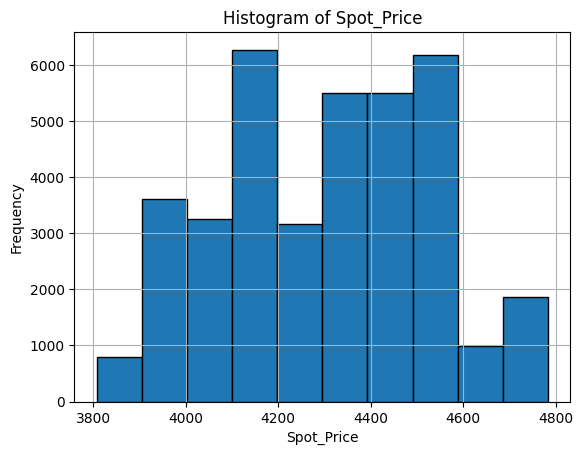

In [57]:
column_name = 'Spot_Price'  

df_filtered[column_name].hist(bins=10, edgecolor='black')
plt.title('Histogram of ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.show()

Distribution of the strike price of the SPX. The strike price of the option. It's the price at which the option can be exercised.

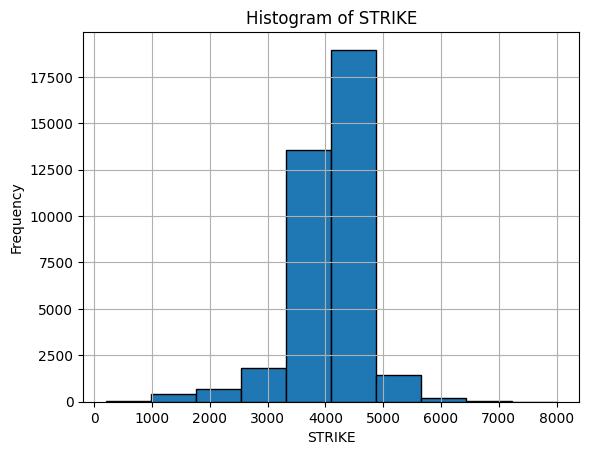

In [58]:
column_name = 'STRIKE'  
df_filtered[column_name].hist(bins=10, edgecolor='black')
plt.title('Histogram of ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.show()

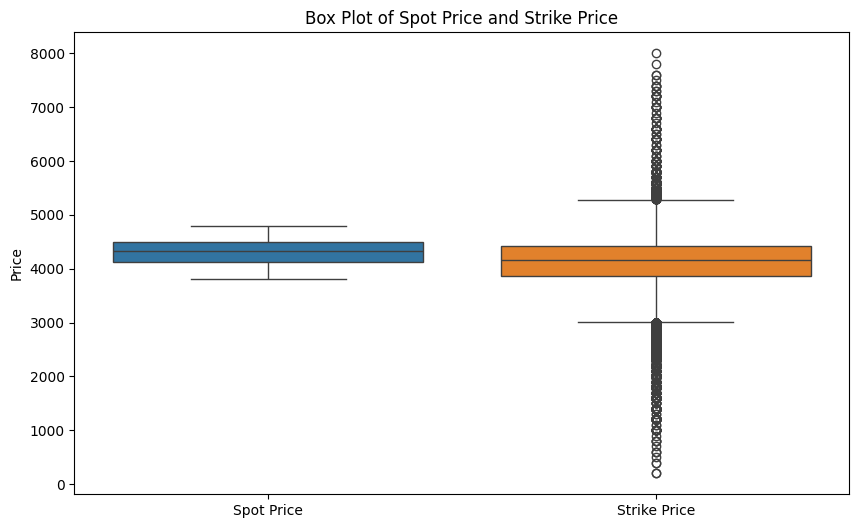

In [59]:
import seaborn as sns

price_comparison_df = df_filtered[['Spot_Price', 'STRIKE']]

# Rename the columns for the boxplot legend
price_comparison_df.columns = ['Spot Price', 'Strike Price']

# Create a box plot for the Spot Price and Strike Price
plt.figure(figsize=(10, 6))
sns.boxplot(data=price_comparison_df)
plt.title('Box Plot of Spot Price and Strike Price')
plt.ylabel('Price')
plt.show()

The range of Strike Prices is broader than that of Spot Prices, which could be due to the various strike prices available across multiple option contracts with different expiration dates.

Histogram of Implied Volatility

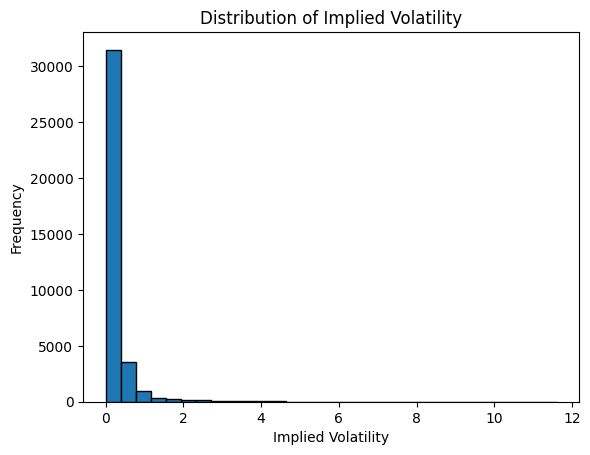

In [60]:
plt.hist(df_filtered['C_IV'], bins=30, edgecolor='k')
plt.title('Distribution of Implied Volatility')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')
plt.show()

Implied volatility approximates the future value of an option, options with high volatility have higher premiums, here our data has low IV which means lower premiums.

Plotting Risk-free rate over time

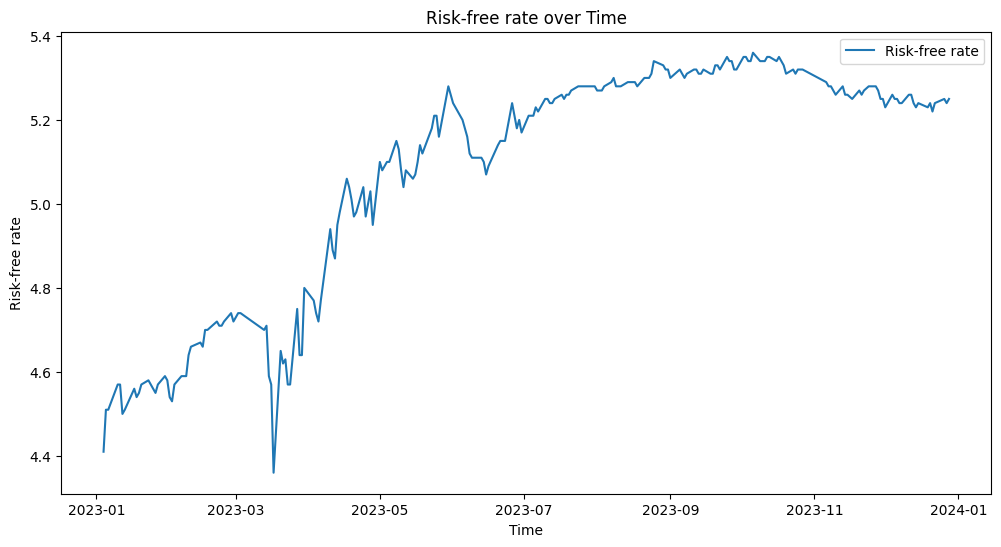

In [61]:
data = df_filtered.sort_values('QUOTE_DATE')

# Plotting spot price over time
plt.figure(figsize=(12, 6))
plt.plot(data['QUOTE_DATE'], data['DTB3'], label='Risk-free rate')
plt.title('Risk-free rate over Time')
plt.xlabel('Time')
plt.ylabel('Risk-free rate')
plt.legend()
plt.show()

Plotting distribution of C_BID

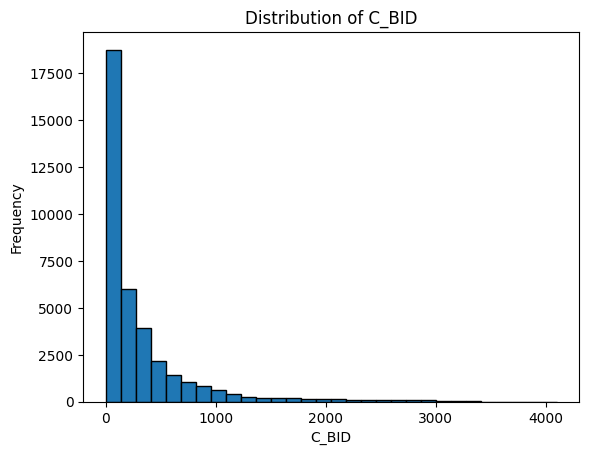

In [62]:
plt.hist(df['C_BID'], bins=30, edgecolor='k')
plt.title('Distribution of C_BID')
plt.xlabel('C_BID')
plt.ylabel('Frequency')
plt.show()

Plotting distribution of C_ASK

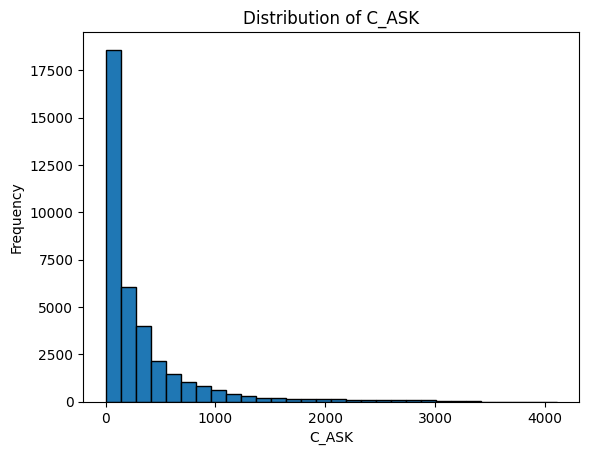

In [63]:
df_filtered['C_ASK'] = pd.to_numeric(df_filtered['C_ASK'], errors='coerce')
plt.hist(df_filtered['C_ASK'], bins=30, edgecolor='k')
plt.title('Distribution of C_ASK')
plt.xlabel('C_ASK')
plt.ylabel('Frequency')
plt.show()

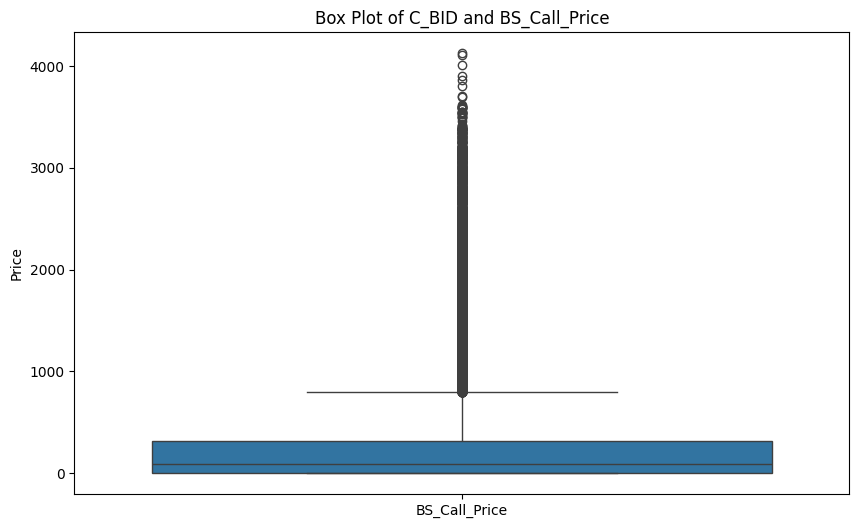

In [64]:
price_comparison_2_df = df_filtered[['C_BID', 'BS_Call_Price']]

# Rename the columns for the boxplot legend
price_comparison_2_df.columns = ['C_BID', 'BS_Call_Price']

# Create a box plot for the Spot Price and Strike Price
plt.figure(figsize=(10, 6))
sns.boxplot(data=price_comparison_2_df)
plt.title('Box Plot of C_BID and BS_Call_Price')
plt.ylabel('Price')
plt.show()

- The median line of BS_Call_Price is lower than that of C_BID, it suggests that the model, on average, prices the options lower than the market is willing to pay.


- BS_Call_Price tends to be lower than C_BID, the model might systematically underestimate the price.

Plotting Spot price over time

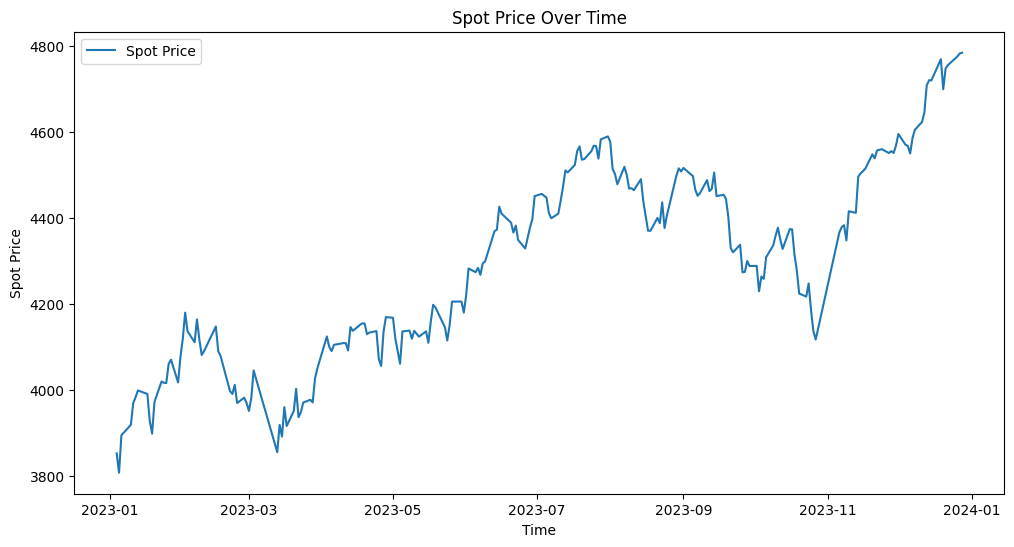

In [65]:
# Sort the DataFrame based on the time column
data = df_filtered.sort_values('QUOTE_DATE')

# Plotting spot price over time
plt.figure(figsize=(12, 6))
plt.plot(data['QUOTE_DATE'], data['Spot_Price'], label='Spot Price')
plt.title('Spot Price Over Time')
plt.xlabel('Time')
plt.ylabel('Spot Price')
plt.legend()
plt.show()

# Future plans:

Our dataset has 37,110 entries with 16 columns
1. **Data Cleaning**: 
    - We have cleaned the data. 

2. **Missing Values**: 
    - We have already handled missing values where ever necessary.

3. **Feature Scaling**: 
    - Features like `Spot_Price`, `STRIKE`, `DTE`, `C_LAST`, `C_BID`, and `C_ASK` have wide ranges. Scaling could be required, because we might plan to use algorithms sensitive to feature scales.

4. **Encoding Categorical Variables**: 
    - Our dataset primarily consists of numerical variables, which is suitable for most machine learning models.

5. **Feature Transformation**:
    - Some columns might benefit from transformation because they have skewed distribution. For instance, financial data often have long-tail distributions, where log transformation could help.
    - The `C_DELTA`, `C_GAMMA`, `C_VEGA`, `C_THETA`, and `C_RHO` have specific distributions due to their nature in financial contexts.

6. **Data Enrichment**:
    - We have already added extra columns for risk-free rate, Spot price and Black-Scholes Call price
    - We plan on enriching our dataset with additional features that could impact option prices, such as adding VIX which is a market volatility index.